## PIC 16b Final Project - Using Time-Series Modeling with Exogenous Predictors to Forecast Energy Consumption

Our goal is develop a time-series model to predict future energy load using a selection of Panamanian data compiled by Ernesto Aguilar Madrid (link: https://data.mendeley.com/datasets/byx7sztj59/1). The data covers roughly 5 and half years, from 2015 to the middle of 2020. Our response variable is a measure of energy consumption at each given timestep, in Megawatts, where intervals of time are recorded in hours. While many time-series models are concerned solely with regressing on the response variable in question, our data set contains a number of predictors that could aid in regression. As the basis for our approach, we will use an ARIMA model, which is itself composed of three consitutent models, those being an Autoregressive (AR) model, an Integrated (I) model, and a Moving Average (MA) model. The autoregressive model predicts future values as a linear combination of some number of past values, while the moving average model does the same with some number of past regression errors. The integrated model applies some amount of differencing, that is examining the differences between values at the various timesteps as opposed to the actual values themselves, and is necessary if our data is non-stationary. We can tune the size of all three constituent models in our ARIMA model parameters. ARIMAX, that is an ARIMA model with exogenous predictors, is the same except it adds a standard linear regression model in addition to the previous three. After applying some degree of differencing, an ARIMAX model is structured according to the following equation, where p and q are the degrees of the autoregressive and moving average models respectively, and n is the number of exogenous variables:
## $y_t = c + \sum_{i=1}^{p}\phi_i y_{t-i} + \sum_{i=1}^{q}\theta_i\epsilon_{t-i} + \epsilon_t + \sum_{i=1}^{n}\beta_i x_{ti}$
We can then begin our analysis by first import the necessary libraries and functions.

In [1]:
import matplotlib.pyplot as plt
import numpy as np
import pandas as pd
from sklearn.metrics import mean_absolute_percentage_error
from statsmodels.tsa.stattools import adfuller
from statsmodels.tsa.arima.model import ARIMA
from statsmodels.graphics.tsaplots import plot_acf
import random
import warnings
warnings.filterwarnings('ignore')
plt.style.use("seaborn")

## Exploratory Data Analysis and Preprocessing

First we will import the data and seperate the "datetime" column into one for date and another for hour. We will also give our predictors more informative names, where Toc, San, and Dav, stand for Tocumen, Santiago, and David respectively, localities in Panama.

In [2]:
load_df = pd.read_csv("continuous dataset.csv") 
load_df["hour"] = load_df["datetime"].str[11:13].astype(int)
load_df["datetime"] = load_df["datetime"].str[0:10]
load_df["datetime"] = pd.to_datetime(load_df["datetime"])
load_df = load_df.rename(columns = {"T2M_toc":"Temp_Toc",
                                    "QV2M_toc":"Humid_Toc",
                                    "TQL_toc":"Precip_Toc",
                                    "W2M_toc":"Wind_Toc",
                                    "T2M_san":"Temp_San",
                                    "QV2M_san":"Humid_San",
                                    "TQL_san":"Precip_San",
                                    "W2M_san":"Wind_San",
                                    "T2M_dav":"Temp_Dav",
                                    "QV2M_dav":"Humid_Dav",
                                    "TQL_dav":"Precip_Dav",
                                    "W2M_dav":"Wind_Dav"})
load_df

,datetime,nat_demand,Temp_Toc,Humid_Toc,Precip_Toc,Wind_Toc,Temp_San,Humid_San,Precip_San,Wind_San,Temp_Dav,Humid_Dav,Precip_Dav,Wind_Dav,Holiday_ID,holiday,school,hour
0,2015-01-03,970.3450,25.865259,0.018576,0.016174,21.850546,23.482446,0.017272,0.001855,10.328949,22.662134,0.016562,0.096100,5.364148,0,0,0,1
1,2015-01-03,912.1755,25.899255,0.018653,0.016418,22.166944,23.399255,0.017265,0.001327,10.681517,22.578943,0.016509,0.087646,5.572471,0,0,0,2
2,2015-01-03,900.2688,25.937280,0.018768,0.015480,22.454911,23.343530,0.017211,0.001428,10.874924,22.531030,0.016479,0.078735,5.871184,0,0,0,3
3,2015-01-03,889.9538,25.957544,0.018890,0.016273,22.110481,23.238794,0.017128,0.002599,10.518620,22.512231,0.016487,0.068390,5.883621,0,0,0,4
4,2015-01-03,893.6865,25.973840,0.018981,0.017281,21.186089,23.075403,0.017059,0.001729,9.733589,22.481653,0.016456,0.064362,5.611724,0,0,0,5
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
48043,2020-06-26,1128.5592,27.246545,0.020303,0.055511,9.289304,25.715295,0.019746,0.121552,1.990773,23.746545,0.018381,0.150879,2.444658,0,0,1,20
48044,2020-06-26,1112.7488,27.099573,0.020395,0.053848,9.837504,25.552698,0.019632,0.153870,2.094459,23.693323,0.018320,0.156311,2.515814,0,0,1,21
48045,2020-06-26,1081.5680,26.971155,0.020448,0.057251,10.262464,25.393030,0.019518,0.144531,2.396369,23.658655,0.018327,0.153259,2.800717,0,0,1,22
48046,2020-06-26,1041.6240,26.867487,0.020464,0.064178,10.326567,25.258112,0.019403,0.108063,2.720871,23.601862,0.018358,0.152771,3.138132,0,0,1,23


---
Here we can see the structure of our data, after seperating "datetime" into one column for date and another for time of day. We have a quantatative response variable, "nat_demand", which indicates energy consumption, 12 weather-based quantatative predictors, and 3 qualatative predictors (now in addition to "hour"). Before we progress further, it is important to first examine the nature of energy consumption per day on an hourly basis.

Text(0, 0.5, 'Energy Consumption (MW/H)')

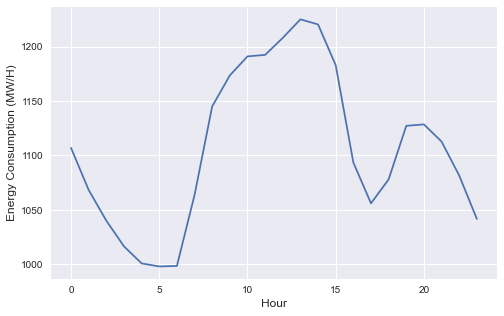

In [3]:
day_df = load_df[load_df["datetime"] == "2020-06-26"]
fig, ax = plt.subplots(figsize = (8,5))
ax.plot(day_df["hour"], day_df["nat_demand"])
ax.set_xlabel("Hour", fontsize = "large")
ax.set_ylabel("Energy Consumption (MW/H)", fontsize = "large")

---
Just by looking at the 26th of June, 2020, we can see a clear relationship between time of day and energy consumption. As one would expect, energy consumption is at its lowest in the early morning, peaks at midday, and then has a smaller peak in the evening. So we in fact have two time-series trends, one by date and another by hour. To avoid over-complicating my model, I decided to remove time of day as a factor and instead focus completely on date to analyze time-series relationships.

In [4]:
load_df["datetime"].value_counts()[load_df["datetime"].value_counts() != 24]

2015-01-03    23
2020-06-27     1
Name: datetime, dtype: int64

---
Two days do not have complete data (i.e. observations for all 24 hours) so we should remove these before progressing. We will also group all of our entries by date and then apply the mean function to all the columns. Two of our categorical variables, "holiday" and "school", are binary indicator variables, but I would like to learn more about the nature of the "Holiday_ID" variable.

In [5]:
revised_load_df = load_df[23:48047]
revised_load_df = revised_load_df.groupby(["datetime"]).mean()
revised_load_df.drop(["hour"], axis = 1, inplace = True)
revised_load_df["Holiday_ID"].value_counts()

0.0     1875
12.0       7
6.0        6
1.0        6
5.0        6
7.0        6
2.0        6
8.0        6
3.0        6
10.0       6
21.0       6
16.0       6
11.0       6
19.0       6
9.0        6
4.0        6
22.0       5
15.0       5
13.0       5
17.0       5
18.0       5
20.0       5
14.0       5
Name: Holiday_ID, dtype: int64

---
We have a large number of different holidays, and in order to encode the information properly we would need 22 indiciator variables which greatly expands the size of the model for the sake of relatively little information. So I have elected to remove the "Holiday_ID" variable all together. We can then visualize the progression of energy consumption over time.

Text(0, 0.5, 'Avergage Energy Consumption (MW/H)')

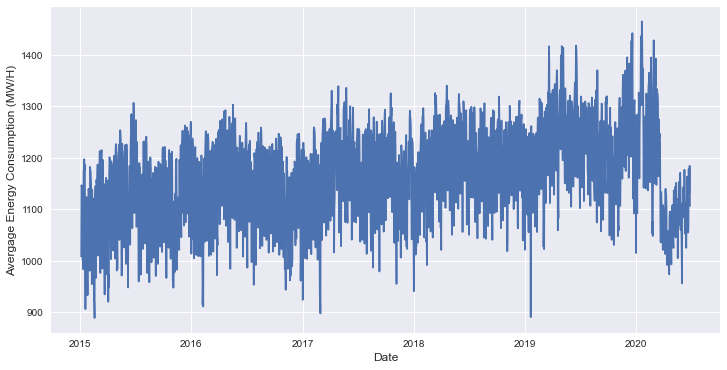

In [6]:
revised_load_df.drop(["Holiday_ID"], axis = 1, inplace = True)
fig, ax = plt.subplots(figsize = (12,6))
ax.plot(revised_load_df.index, revised_load_df["nat_demand"])
ax.set_xlabel("Date", fontsize = "large")
ax.set_ylabel("Avergage Energy Consumption (MW/H)", fontsize = "large")

---
Here we can see the general course of energy demand from 2015 to 2020. We can observe a slight, gradual trend by which demand increases with time. There is also a pattern of seasonality, and energy demand appears highest in the summer and lowest in winter, which is logical for a country with tropical weather. Finally, there is a substantial decrease in consumption in 2020, which was likely caused by lockdowns due to Covid-19. We can then use the augmented Dickey-Fuller test to detirmine if our data is in fact non-stationary.

In [7]:
adf_results = adfuller(revised_load_df["nat_demand"])
print("p-value: " + str(adf_results[1]))

p-value: 0.006507283335402192


---
By way of the augmented Dickey-Fuller test, for a 99% confidence level we have that our data is stationary. As such we do not need to include differencing in our model. We can then visualize autocorrelation.

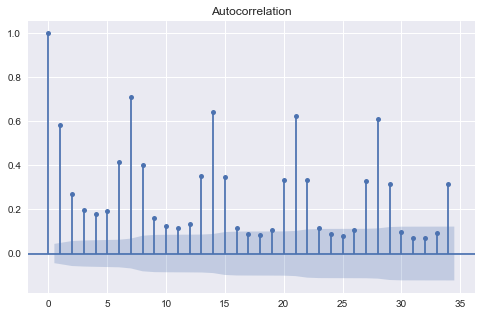

In [8]:
fig, ax = plt.subplots(figsize = (8,5))
p = plot_acf(revised_load_df["nat_demand"], ax)

---
From the ACF plot, we have fairly strong visual evidence of autocorrelation, which seems to follow a seasonal pattern. This reinforces our previous observation of seasonality in energy consumption. ARIMA models can be enhanced with a seasonal model component to solve for such patterns, but we should first examine the time-series patterns in the exogenous predictors themselves. I selected the first 4, concerning Tocumen, for inspection.

Text(0, 0.5, 'Tocumen Wind Speed ($m/s$)')

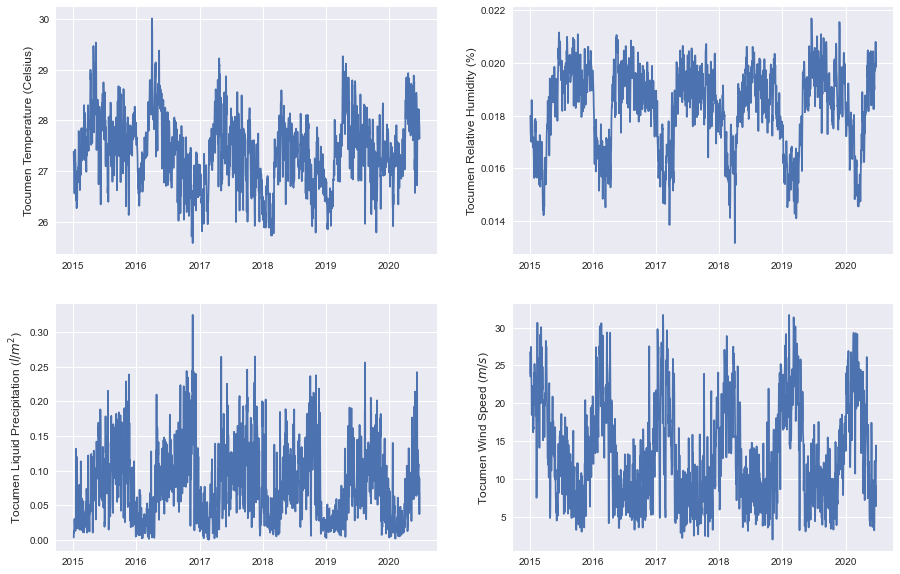

In [9]:
fig, ax = plt.subplots(nrows = 2, ncols = 2, figsize = (15,10))
ax[0, 0].plot(revised_load_df["Temp_Toc"])
ax[0, 0].set_ylabel("Tocumen Temperature (Celsius)", fontsize = "large")
ax[0, 1].plot(revised_load_df["Humid_Toc"])
ax[0, 1].set_ylabel("Tocumen Relative Humidity (%)", fontsize = "large")
ax[1, 0].plot(revised_load_df["Precip_Toc"])
ax[1, 0].set_ylabel("Tocumen Liquid Precipitation ($l/m^2$)", fontsize = "large")
ax[1, 1].plot(revised_load_df["Wind_Toc"])
ax[1, 1].set_ylabel("Tocumen Wind Speed ($m/s$)", fontsize = "large")

---
Our predictors themselves clearly display strong seasonal patterns, so we likely do not need to incorporate a seasonal order in our model. Relying on actual predictor values will also probably improve the capacity to approximate local structure and predict small shocks in energy consumption, as opposed to fitting a more general seasonal order. The final step of data pre-processing is to unitize our numerical predictors so that all of the values range from 0 to 1.

In [10]:
for column in revised_load_df.columns:
    if column != "nat_demand":
        revised_load_df[column] = revised_load_df[column]/revised_load_df[column].max()
revised_load_df

,nat_demand,Temp_Toc,Humid_Toc,Precip_Toc,Wind_Toc,Temp_San,Humid_San,Precip_San,Wind_San,Temp_Dav,Humid_Dav,Precip_Dav,Wind_Dav,holiday,school
datetime,,,,,,,,,,,,,,,
2015-01-04,1008.123596,0.912525,0.829377,0.011673,0.743147,0.832539,0.839410,0.040260,0.632596,0.872574,0.840972,0.259668,0.570332,0.0,0.0
2015-01-05,1146.682925,0.905486,0.825603,0.041121,0.845609,0.825323,0.817289,0.047129,0.743184,0.868372,0.808512,0.244370,0.824923,0.0,0.0
2015-01-06,1143.394429,0.899792,0.801858,0.033428,0.836641,0.821731,0.809484,0.044524,0.722271,0.858735,0.799332,0.240853,0.799467,0.0,0.0
2015-01-07,1144.098817,0.888957,0.795023,0.053822,0.754685,0.799401,0.785418,0.073489,0.682321,0.838238,0.769516,0.258550,0.802410,0.0,0.0
2015-01-08,1137.586800,0.885075,0.785674,0.094298,0.866547,0.801023,0.779188,0.118524,0.772936,0.836103,0.770661,0.276494,0.886339,0.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
2020-06-22,1177.745404,0.936919,0.929429,0.280231,0.205232,0.863934,0.901059,0.229983,0.210882,0.902416,0.881166,0.251429,0.287519,0.0,1.0
2020-06-23,1137.366342,0.940062,0.958908,0.198630,0.286118,0.868164,0.943760,0.208880,0.160299,0.905418,0.964102,0.348732,0.378953,0.0,1.0
2020-06-24,1131.196625,0.931725,0.915086,0.211093,0.201051,0.854344,0.916707,0.197456,0.238753,0.894446,0.899979,0.258708,0.253853,0.0,1.0


## Constructing the ARMAX Model

As our data is statistically stationary, we will only use the ARMA parameters as opposed to the full ARIMA model. When I experimented with differencing by adding an integrated model componnet, I achieved comparatively poor forecast performance. To solve for the clear drift visible in the progression of energy consumption, I decided to add a simple, linear trend which is supported by the Statsmodels ARIMA( ) function. While we are using the ARIMA( ) function, by setting d = 0 our model with be expressed in terms of ARMA parameters. To detirmine the proper order of our model, that is the number of autoregressive and moving average parameters respectively, I developed a semi-rigorous approach to detirmine the optimal model in terms of the BIC (Bayesian Information Criterion) score. I chose BIC over AIC (Akaike Information Criterion) to more strongly penalize overfitting. At each iteration, our approach randomly raises either p or q by 1, then produces an ARIMA model and detirmines the BIC score. If at any point increasing model complexity raises the BIC, we then "freeze" the parameter in question and lower it by 1. Once both parameters are "frozen" we produce a data frame containing various models and the respective BIC scores.

In [11]:
p = 0
q = 0
status = ["open", "open"]
bic_list = []
params_list = []
j = 0
while (status != ["closed", "closed"]):
    num = np.random.choice([0,1])
    if (j == 0):
        p += 1
        q += 1
    elif ((num == 0 and status[0] != "closed") or
          (status[0] != "closed" and status[1] ==  "closed")):
        p += 1
    elif ((num == 1 and status[1] != "closed") or
          (status[0] == "closed" and status[1] !=  "closed")):
        q += 1
    ARIMA_model = ARIMA(revised_load_df["nat_demand"],
                        exog = revised_load_df.drop(["nat_demand"], axis = 1),
                        order = (p,0,q),
                        trend = "ct")
    ARIMA_results = ARIMA_model.fit()
    bic_list += [ARIMA_results.bic]
    params_list += [(p,q)]
    if (len(bic_list) > 1):
        if (bic_list[j] > bic_list[j - 1]):
            if ((num == 0 and status[0] != "closed") or
                (status[0] != "closed" and status[1] ==  "closed")):
                status[0] = "closed"
                p -= 1
            elif ((num == 1 and status[1] != "closed") or
                  (status[0] == "closed" and status[1] !=  "closed")):
                status[1] = "closed"
                q -= 1
    j += 1
data = list(zip(params_list, bic_list))
p_q_scores = pd.DataFrame(data, columns = ["ARMA Parameters", "BIC"])
p_q_scores

,ARMA Parameters,BIC
0,"(1, 1)",22740.154762
1,"(2, 1)",22668.485037
2,"(2, 2)",22522.850897
3,"(2, 3)",22691.286249
4,"(3, 2)",22518.405906
5,"(4, 2)",22460.230055
6,"(5, 2)",22368.419213
7,"(6, 2)",21623.720553
8,"(7, 2)",20967.573953
9,"(8, 2)",20963.317185


---
Here we can see the results of our search in terms in terms of respective BIC scores. The ARMA parameters that account for the lowest BIC score will then be recorded and used for all of our models moving forward.

In [12]:
best_p_q = p_q_scores.sort_values(by = "BIC")
best_p_q.reset_index(inplace = True)
p = best_p_q["ARMA Parameters"][0][0]
q = best_p_q["ARMA Parameters"][0][1]
print("Optimal Model Order: " + str(p) + ", 0, " + str(q))

Optimal Model Order: 8, 0, 2


---
We can then construct our model. For our first two models we will use the entire period as training data and then produce in-sample forecasts.

In [13]:
ARIMA_model = ARIMA(revised_load_df["nat_demand"],
                    exog = revised_load_df.drop(["nat_demand"], axis = 1),
                    order = (p,0,q),
                    trend = "ct")
ARIMA_results = ARIMA_model.fit()
print(ARIMA_results.summary())

                               SARIMAX Results                                
Dep. Variable:             nat_demand   No. Observations:                 2001
Model:                 ARIMA(8, 0, 2)   Log Likelihood              -10379.040
Date:                Wed, 09 Jun 2021   AIC                          20812.079
Time:                        21:17:09   BIC                          20963.317
Sample:                    01-04-2015   HQIC                         20867.609
                         - 06-26-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        829.3070     73.484     11.286      0.000     685.282     973.332
drift          0.0498      0.014      3.681      0.000       0.023       0.076
Temp_Toc    -188.0946     92.920     -2.024      0.0

---
Above are all the parameters for the model. Thanks to unitization, the variance of the magnitude of the coefficients is not too great. The statistical tests at the bottom also reveal some facts about the residuals. Our high p-value for the Ljung-Box test implies that the residuals do not exhibit serial autocorrelation, while the low p-value for the Jarque-Bera test indicates that the residuals are not normally distributed. This is reinforced by our kurtosis, which at 4.30 is higher than that of the Guassian distribution at 3. The distribution is also skewed slightly to the left. The next step is to produce predicted values for the whole period of 2015 to 2020. We will produce two forecasts, one that is non-dynamic and another that is dynamic. When predicting the next value, the non-dynamic forecast uses the actual ground truth data for the endogenous variable. For example, the non-dynamic forecast is able to predict the energy load for June 26th, 2020 with full knowledge of all observed data for the period up to June 25th, 2020. While the dynamic forecast uses the same coefficients produced with all the training data, at each timestep it only takes into account previously predicted, as opposed to actually observed, values for the purposes of the constituent autoregressive and moving average models.

<function matplotlib.pyplot.show(close=None, block=None)>

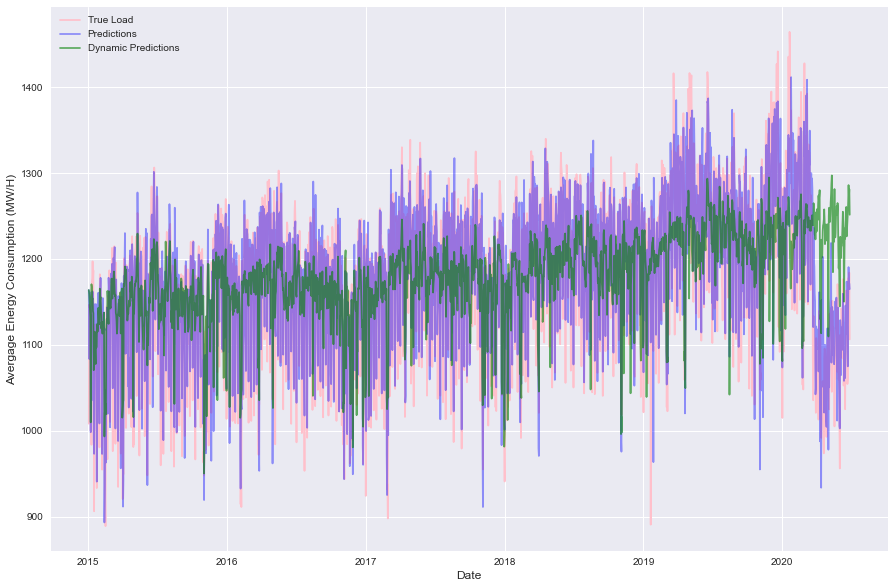

In [14]:
ARIMA_predict = ARIMA_results.get_prediction(exog =
                                             revised_load_df.drop(["nat_demand"], axis = 1))
ARIMA_dynamic_predict = ARIMA_results.get_prediction(exog =
                                                     revised_load_df.drop(["nat_demand"], axis = 1),
                                                     dynamic = True)
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(revised_load_df["nat_demand"], color = "pink", label = "True Load")
ax.plot(ARIMA_predict.predicted_mean, color = "blue", alpha = 0.4, label = "Predictions")
ax.plot(ARIMA_dynamic_predict.predicted_mean, color = "green", alpha = 0.6,
        label = "Dynamic Predictions")
ax.set_xlabel("Date", fontsize = "large")
ax.set_ylabel("Avergage Energy Consumption (MW/H)", fontsize = "large")
ax.legend()
plt.show

---
Both forecasts are able to approximate the general structure of energy consumption over time fairly well. Not suprisingly, the non-dynamic forecast follows the actual energy load more closely. However, the dynamic forecast is still able to capture the general trend, seasonality, and smaller shocks in consumption. That we are able to capture seasonality without adding a seasonal order to our model thanks to our exogenous predictors reinforces our previous observation. Interestingly, the dynamic forecast shows less variance than either the non-dynamic forecast or the true load. The dynamic forecast is also unable to predict the large shock caused by Covid-19 lockdowns. To measure the accuracy of the forecast, we will use the Mean Absolute Percentage Error, provided by the formula below, where $A_t$ is the actual, observed value for some time and $F_t$ is the forecasted value:
## $\\MAPE = \frac{100}{n}\sum_{t=1}^{n}|\frac{A_t-F_t}{A_t}|$

In [15]:
print("Predicted MAPE = " +
      str(np.round(mean_absolute_percentage_error(revised_load_df["nat_demand"],
                                                  ARIMA_predict.predicted_mean)*100,2))
      + " %")
print("Dynamically Predicted MAPE = " +
      str(np.round(mean_absolute_percentage_error(revised_load_df["nat_demand"],
                                                  ARIMA_dynamic_predict.predicted_mean)*100,2))
      + " %")
in_sample_residuals = revised_load_df["nat_demand"] - ARIMA_dynamic_predict.predicted_mean

Predicted MAPE = 2.82 %
Dynamically Predicted MAPE = 5.5 %


---
The non-dynamic in-sample forecast has a fairly low error rate, but so too does the dynamic in-sample forecast. The discrepancy between the two is likely influenced by the inability of the dynamic forecast to predict the effect of Covid-19 lockdowns on energy consumption. We can then produce another model, however this time without predictors deemed insignificant at the 90% confidence level, which are interestingly all from the city of David.

In [16]:
Insignificant_exogs = ["nat_demand", "Temp_Dav", "Humid_Dav", "Wind_Dav"]
ARIMA_model = ARIMA(revised_load_df["nat_demand"],
                    exog = revised_load_df.drop(Insignificant_exogs, axis = 1),
                    order = (p,0,q),
                    trend = "ct")
ARIMA_results = ARIMA_model.fit()
print(ARIMA_results.summary())

                               SARIMAX Results                                
Dep. Variable:             nat_demand   No. Observations:                 2001
Model:                 ARIMA(8, 0, 2)   Log Likelihood              -10378.237
Date:                Wed, 09 Jun 2021   AIC                          20804.475
Time:                        21:17:22   BIC                          20938.908
Sample:                    01-04-2015   HQIC                         20853.835
                         - 06-26-2020                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        835.3174     69.512     12.017      0.000     699.077     971.558
drift          0.0496      0.013      3.673      0.000       0.023       0.076
Temp_Toc    -175.8605     93.023     -1.891      0.0

---
After removing insignificant exogenous predictors our statistical tests are similar in their outcomes. The skew and kurtosis of our residuals are also effectively the same.

<function matplotlib.pyplot.show(close=None, block=None)>

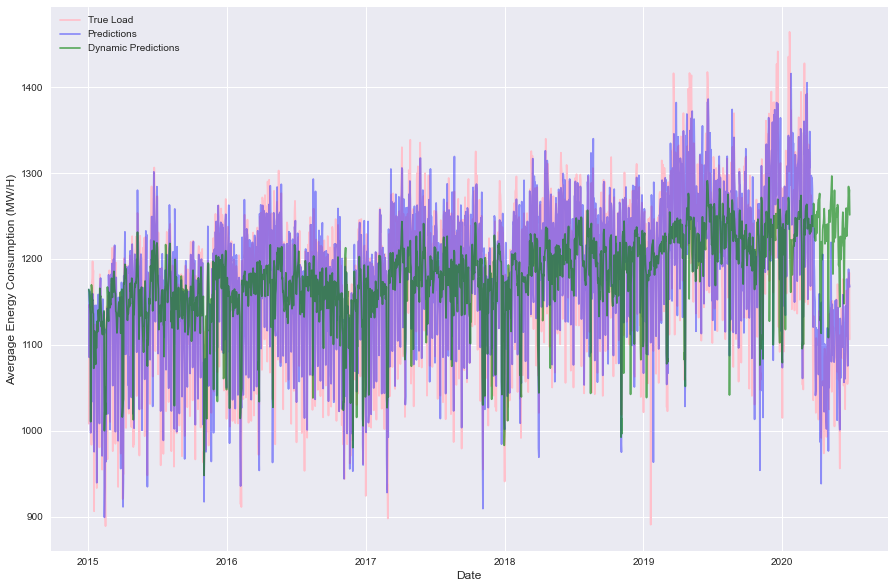

In [17]:
ARIMA_predict = ARIMA_results.get_prediction(exog =
                                             revised_load_df.drop(Insignificant_exogs, axis = 1))
ARIMA_dynamic_predict = ARIMA_results.get_prediction(exog =
                                                     revised_load_df.drop(Insignificant_exogs, axis = 1),
                                                     dynamic = True)
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(revised_load_df["nat_demand"], color = "pink", label = "True Load")
ax.plot(ARIMA_predict.predicted_mean, color = "blue", alpha = 0.4, label = "Predictions")
ax.plot(ARIMA_dynamic_predict.predicted_mean, color = "green", alpha = 0.6,
        label = "Dynamic Predictions")
ax.set_xlabel("Date", fontsize = "large")
ax.set_ylabel("Avergage Energy Consumption (MW/H)", fontsize = "large")
ax.legend()
plt.show

---
From visual inspection, the predictive capacity of both the non-dynamic and the dynamic forecasts is similar. Both forecasts capture all the essential components of the true progression of energy consumption, and the dynamic forecast likewise fails to predict the drop-off caused by Covid-19 lockdowns.

In [18]:
print("Predicted MAPE = " +
      str(np.round(mean_absolute_percentage_error(revised_load_df["nat_demand"],
                                                  ARIMA_predict.predicted_mean)*100,2))
      + " %")
print("Dynamically Predicted MAPE = " +
      str(np.round(mean_absolute_percentage_error(revised_load_df["nat_demand"],
                                                  ARIMA_dynamic_predict.predicted_mean)*100,2))
      + " %")

Predicted MAPE = 2.82 %
Dynamically Predicted MAPE = 5.5 %


---
Removing statistically insignificant exogenous predictors does not lead to a substantial change in model performance. The BIC score for the second model is also slightly lower. So I decided to remove them for the final out-of-sample forecast to prevent overfitting.

## Out-of-Sample Performance

With the previous two models, our forecasts were all in-sample. To get a sense of the true accuracy of the model we should then produce an out-of-sample forecast. We can train the parameters (both for ARMA and for exogenous regression) on some subset of time and then produce a forecast for a subsequent subset of time. I decided to train the model on the period beginning January 1, 2015 and ending on December 31, 2018, and then use 2019 as the forecast year. I elected to ignore 2020 for the purposes of testing the model, as the shock of Covid-19 on energy consumption is likely impossible to capture in an out-of-sample forecast for our given set of exogenous predictors.

In [19]:
ARIMA_model = ARIMA(revised_load_df["nat_demand"]["01-01-2015":"31-12-2018"],
                    exog = revised_load_df.drop(Insignificant_exogs, axis = 1)
                    ["01-01-2015":"31-12-2018"],
                    order = (p,0,q),
                    trend = "ct")
ARIMA_results = ARIMA_model.fit()
print(ARIMA_results.summary())

                               SARIMAX Results                                
Dep. Variable:             nat_demand   No. Observations:                 1458
Model:                 ARIMA(8, 0, 2)   Log Likelihood               -7399.497
Date:                Wed, 09 Jun 2021   AIC                          14846.993
Time:                        21:17:31   BIC                          14973.829
Sample:                    01-04-2015   HQIC                         14894.311
                         - 12-31-2018                                         
Covariance Type:                  opg                                         
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        256.0978     63.537      4.031      0.000     131.567     380.628
drift          0.0873      0.006     14.758      0.000       0.076       0.099
Temp_Toc     605.1452     96.752      6.255      0.0

---
Statistical facts about the residuals are somewhat similar. They are apparently more autocorrelated than they were for the first and second models, and for a 99% level of confidence are not normally distributed. Kurtosis is similar, but slightly higher, and the left skew is greater in magnitude.

<function matplotlib.pyplot.show(close=None, block=None)>

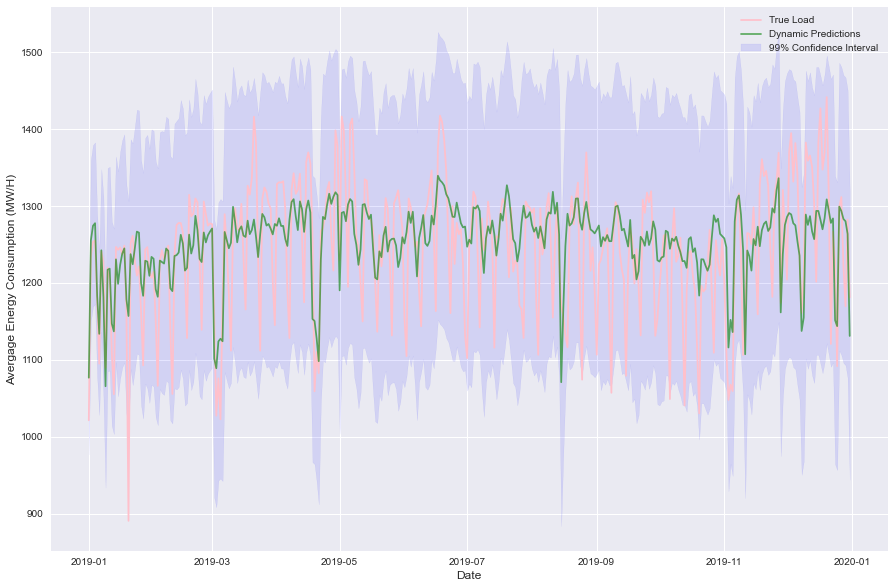

In [20]:
ARIMA_dynamic_predict = ARIMA_results.get_prediction(start = "01-01-2019",
                                                     end = "31-12-2019",
                                                     exog =
                                                     revised_load_df.drop(Insignificant_exogs, axis = 1)
                                                     ["01-01-2019":"31-12-2019"],
                                                     dynamic = True)
conf_interval = ARIMA_dynamic_predict.conf_int(alpha = 0.01)
fig, ax = plt.subplots(figsize = (15,10))
ax.plot(revised_load_df["nat_demand"]["01-01-2019":"31-12-2019"],
        color = "pink", label = "True Load")
ax.plot(ARIMA_dynamic_predict.predicted_mean["01-01-2019":"31-12-2019"],
        color = "green", alpha = 0.6,
        label = "Dynamic Predictions")
plt.fill_between(x = conf_interval.index,
                 y1 = conf_interval["lower nat_demand"],
                 y2 = conf_interval["upper nat_demand"],
                 color = "blue", alpha = 0.1,
                 label = "99% Confidence Interval")
ax.set_xlabel("Date", fontsize = "large")
ax.set_ylabel("Avergage Energy Consumption (MW/H)", fontsize = "large")
ax.legend()
plt.show

---
The graph above shows a strong connection between the forecasted and the observed values. Not only is the forecast able to capture the general structure of energy consumption in 2019, with regards to e.g. seasonal trends, but it is able to predict the smaller shocks with a certain degree of accuracy. However, while the forecast is generally able to detirmine the time of a shock and its direction (positive or negative), it is sometimes too conservative with regards to the magnitude. This seems to be especially true when the shock is negative, which could explain the skew of our residuals. Where the true load either exceeds or is less than the predicted value, it still almost always falls within the confidence interval.

In [21]:
print("Dynamically Predicted MAPE = " +
      str(np.round(mean_absolute_percentage_error(revised_load_df["nat_demand"]
                                                 ["01-01-2019":"31-12-2019"],
                                                 ARIMA_dynamic_predict.predicted_mean
                                                 ["01-01-2019":"31-12-2019"])*100,2))
      + " %")
y_t = revised_load_df["nat_demand"]["01-01-2019":"31-12-2019"]
y_hat = ARIMA_dynamic_predict.predicted_mean["01-01-2019":"31-12-2019"]
out_of_sample_residuals = y_t - y_hat

Dynamically Predicted MAPE = 4.35 %


---
Our dynamic out-of-sample forecast is strong with such a low error rate, and reflects well on the predictive ability of our modeling approach. Armed only with knowledge about the exogenous predictors themselves and nothing regarding the actual values for energy consumption during 2019, we are able predict the daily energy load for the whole year with an average error of roughly 4%. We can then visualize the autocorrelation of the residuals, and compare them against those from our first model which contained the statistically insignificant exogenous for the period in question, that being 2019.

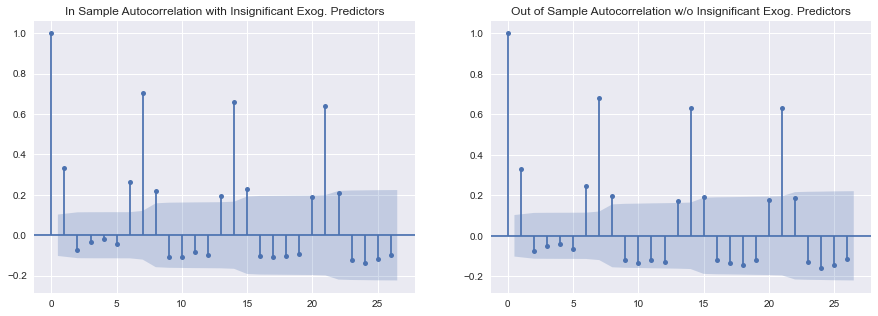

In [22]:
fig, ax = plt.subplots(nrows = 1, ncols = 2, figsize = (15,5))
in_sample_residuals = in_sample_residuals["01-01-2019":"31-12-2019"]
p = plot_acf(in_sample_residuals, ax[0], title =
         "In Sample Autocorrelation with Insignificant Exog. Predictors")
p = plot_acf(out_of_sample_residuals, ax[1], title =
         "Out of Sample Autocorrelation w/o Insignificant Exog. Predictors")

---
These autocorrelation plots somewhat contradict the earlier results of the respective Ljung-Box tests. Both of our sets of residuals display some degree of autocorrelation. We can then visualize the general distribution of both sets of residuals.

In Sample w/ Insignificant Exogs. Residual Mean: 27.277652118896587
Out of Sample w/o Insignificant Exogs. Residual Mean: -10.658649846857752


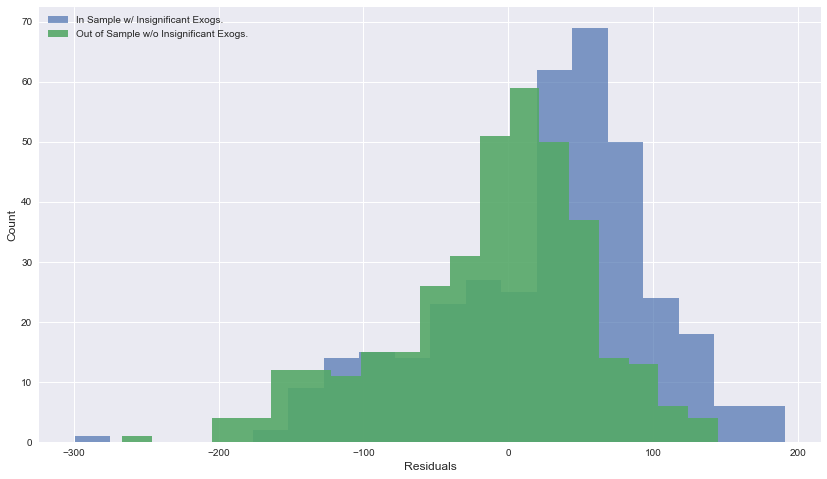

In [23]:
fig, ax = plt.subplots(figsize = (14,8))
ax.set_xlabel("Residuals", fontsize = "large")
ax.set_ylabel("Count", fontsize = "large")
ax = plt.hist(in_sample_residuals,
              bins = 20,
              label = "In Sample w/ Insignificant Exogs.",
              alpha = 0.7)
ax = plt.hist(out_of_sample_residuals,
              bins = 20,
              label = "Out of Sample w/o Insignificant Exogs.",
              alpha = 0.9)
plt.legend()
print("In Sample w/ Insignificant Exogs. Residual Mean: " + str(np.mean(in_sample_residuals)))
print("Out of Sample w/o Insignificant Exogs. Residual Mean: " + str(np.mean(out_of_sample_residuals)))

---
Interestingly, while all three of our models displayed negative skewness, here the in-sample residuals for 2019 are positively skewed. The out-of-sample residuals display negative skewness as expected. Both are leptokurtic, i.e. they have greater tailedness than the Gaussian distribution. Our goal is to achieve residuals that are distributed according to a white noise process, i.e. they have a mean of 0, some finite variance, and are not autocorrelated. Neither of our sets of residuals appear to meet this standard.

## Conclusion

For this particular dataset, I think it is fair to say that adding exogenous predictors into our ARMA model improved the predictive capacity. First and foremost, said predictors allow the model to capture seasonality without us having to add a seasonal order and detirmine the proper parameter values. As can be examined closely with the out-of-sample forecast graph, the forecast is also able to pinpoint with some accuracy local shocks, which seem to be correlated with our exogenous predictors. However, with such a model it is impossible to produce a forecast for some period when one does not have a strong sense of the likely or actual values of the given set of exogenous predictors.

When it comes to coefficient values, only the ones produced by the third model appear logical. For example, in our first model increases in temperature in Tocumen lower overall energy demand while the reverse is true in Santiago, by roughly the same magnitude, which is somewhat nonsensical. Removing insignificant exogenous predictors does not appear to improve the interpretability in this regard. It could be that the inclusion of the Covid-19 shock leads to such anomalies, which are again missing from our third model. According to our third model, temperature increases in both Tocumen and Santiago raise overall energy demand, as is true of humidity, which is logical for a tropical country. Precipitation in both cities lowers energy demand, which makes sense given the decline in demand during the winter. Greater wind speed in Tocumen lowers demand, while the reverse is true in Santiago. Interestingly, the magnitude of all our predictors regarding Tocumen are greater than those of Santiago, and seem to be roughly 2 to 4 times larger, with the exception of wind. Our only coefficient regarding David indicates that precipitation there lowers overall energy demand. Here it is however important to remember that all coefficient values were produced with regards to unitized data.

The assumption that we have made in constructing these models, i.e. that there exists a simple linear relationship between each individual predictor and the response variable is not exactly reasonable. It seems likely that there are a variety of non-linear relationships that we cannot infer from our relatively simple model. While our model is fairly easy to understand, we could potentially achieve a higher degree of accuracy by building a model with a neural network (e.g. RNN or LSTM). This could allow us to explore a much wider range of potential relationships between the predictors and our response variable without imposing simplistic and linear constraints on our model.